<b><font size=5>**Introduction**</font></b>

The notebook is divided into two parts, each of which is divided into steps:

- [Part 1: Road Segmentation](#part-1-road-segmentation)
  - [Step 1.1: Data Preparation](#step-11-data-preparation)
  - [Step 1.2: Model Training](#step-12-model-training)
  - [Step 1.3: Application to MIPT Campus](#step-13-application-to-mipt-campus)
- [Part 2: Road Network Graph Construction](#part-2-road-network-graph-construction)
  - [Step 2.1: Skeletonization](#step-21-skeletonization)
  - [Step 2.2: Graph Node Extraction](#step-22-graph-node-extraction)
  - [Step 2.3: Point Clustering](#step-23-point-clustering)
  - [Step 2.4: Graph Edge Extraction](#step-23-graph-edge-extraction)
  - [Step 2.5: Final Graph](#step-23-final-graph)

This notebook presents a pipeline for training **UNet** and **DeepLabV3** segmentation models to obtain a road map of the **MIPT (Moscow Institute of Physics and Technology)** campus (part $1$) and a pipeline for constructing a road graph based on the map (part $2$).

The project was carried out in a Kaggle environment with a P100 GPU.

Let's make the necessary imports:

In [ ]:
!pip install pytorch_lightning

In [5]:
# Standard library utilities
import os
import time
from collections import defaultdict
from functools import lru_cache
from glob import glob

# Libraries for data analysis
import numpy as np
import pandas as pd

# Libraries for image processing
import albumentations as A
import cv2
import networkx as nx
import torchvision.transforms as transforms
from albumentations.pytorch import ToTensorV2
from PIL import Image
from scipy.ndimage import convolve
from scipy.spatial import KDTree
from shapely.geometry import LineString
from shapely.ops import linemerge
from skimage.morphology import skeletonize
from sklearn.cluster import DBSCAN
from skimage.measure import label, regionprops

# Libraries for visualization
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
sns.set()

# Libraries for learning
import pytorch_lightning as pl
import torch
import torch.optim as optim
import torchmetrics
import torchvision
import wandb
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics.classification import JaccardIndex, BinaryJaccardIndex
from torchvision import models
from tqdm.notebook import tqdm

# Libraries for networking and authorization
import gdown
import requests
from io import BytesIO
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

# Disabling warnings
import warnings
warnings.filterwarnings('ignore')

# Models, dataset and utils
from src.models import UNetLightningModel, DeepLabV3LightningModel
from src.dataset import DeepGlobeDataset
from src.utils import predict_mask_grid, cluster_mask_points, plot_graph_overlay

---
<a name="part-1-road-segmentation"></a>
# <b><font size=5>**Part $1$:**</font></b>

In this part, we will be training segmentation models and obtaining a road map.

<a name="step-11-data-preparation"></a>
<b><font size=3>**Step $1.1$:**</font></b>

In this step, we will get the training data.

For training, we will use the [DeepGlobe Road Extraction Dataset](https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset), which contains approximately $6$k images, each $1024$x$1024$, with a scale of $50$cm per pixel.


Let's download it:

In [ ]:
import kagglehub

# Download latest version
path_deepglobe = kagglehub.dataset_download("balraj98/deepglobe-road-extraction-dataset")

print("Path to dataset files:", path_deepglobe)

Path to dataset files: /kaggle/input/deepglobe-road-extraction-dataset


Let's take a look at the contents of the folder:

In [ ]:
!ls /kaggle/input/deepglobe-road-extraction-dataset

class_dict.csv	metadata.csv  test  train  valid


Then we take a look at the contents of the train:

In [ ]:
!ls /kaggle/input/deepglobe-road-extraction-dataset/train | head -n 10

100034_mask.png
100034_sat.jpg
100081_mask.png
100081_sat.jpg
100129_mask.png
100129_sat.jpg
100703_mask.png
100703_sat.jpg
100712_mask.png
100712_sat.jpg
ls: write error: Broken pipe


There are no masks for validation and testing in this dataset, so we will only use the train set. Let's read the images and get a list of objects for training:

In [ ]:
deepglobe_images = []
deepglobe_masks = []

deepglobe_read_transform = A.Compose([
    A.Resize(width=256, height=256)
])

for file_name in tqdm(os.listdir(path_deepglobe + '/train')):
  if file_name.endswith('.png'):
    continue

  image = cv2.imread(path_deepglobe + '/train/' + file_name)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = deepglobe_read_transform(image=image)['image']
  deepglobe_images.append(image)

  mask_name = file_name.replace('_sat.jpg', '_mask.png')
  mask = cv2.imread(path_deepglobe + '/train/' + mask_name, cv2.IMREAD_GRAYSCALE)
  _, mask = cv2.threshold(mask, 127, 1, cv2.THRESH_BINARY)
  mask = mask.astype(np.float32)
  mask = deepglobe_read_transform(image=mask)['image']
  deepglobe_masks.append(mask)

<a name="step-12-model-training"></a>
<b><font size=3>**Step 1.2:**</font></b>

In this step, we will be training models.

We have quite a few images, so let's allocate $20\%$ for testing and define loaders. We will use various transformations from the Albumentations library:

In [ ]:
deepglobe_train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.3),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.Perspective(scale=(0.05, 0.1), p=0.2),
    A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.3),
    A.Normalize(mean=(0, 0, 0), std=(255, 255, 255)),
    ToTensorV2()
])

deepglobe_val_transform = A.Compose([
    A.Normalize(mean=(0, 0, 0), std=(255, 255, 255)),
    ToTensorV2()
])

deepglobe_images_train, deepglobe_images_val, deepglobe_masks_train, deepglobe_masks_val = train_test_split(
    deepglobe_images, deepglobe_masks, test_size=0.2, random_state=42
)

train_dataset_deepglobe = DeepGlobeDataset(deepglobe_images_train, deepglobe_masks_train, deepglobe_train_transform)
val_dataset_deepglobe = DeepGlobeDataset(deepglobe_images_val, deepglobe_masks_val, deepglobe_val_transform)

batch_size_deepglobe = 32

num_workers = max(os.cpu_count() - 2, 1)

train_loader_deepglobe = DataLoader(
    train_dataset_deepglobe,
    batch_size=batch_size_deepglobe,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)
val_loader_deepglobe = DataLoader(
    val_dataset_deepglobe,
    batch_size=batch_size_deepglobe,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

Let's log in to `wandb`:

In [ ]:
wandb.login(key='', relogin=True)
wandb.finish()

Now we will train UNet with `lr=1e-4, weight_decay=1e-2` for $50$ epochs:

In [ ]:
wandb.init(project='CV-spring-2025', name='unet-deepglobe-run-38')

lightning_unet_deepglobe = UNetLightningModel(lr=1e-4, weight_decay=1e-2)

checkpoint_callback_unet_deepglobe = ModelCheckpoint(
    monitor='val_iou',
    mode='max',
    dirpath='checkpoints/',
    filename='best-unet-deepglobe',
    save_top_k=1,
    save_last=True
)

torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
trainer_unet_deepglobe = pl.Trainer(
    accelerator='gpu',
    precision='32-true',
    max_epochs=50,
    callbacks=[checkpoint_callback_unet_deepglobe, TQDMProgressBar(refresh_rate=10)],
    logger=pl.loggers.WandbLogger(project='CV-spring-2025', log_model=False)
)

trainer_unet_deepglobe.fit(lightning_unet_deepglobe, train_loader_deepglobe, val_loader_deepglobe)

Then we finish the run:

In [ ]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█████
train_iou,▁▁▁▁▁▁▁▁▁▁▃▄▅▅▄▆▆▅▅▇▆▇▇▇▆▇█▇▇▆▇▇▇█▇▇▇▇▇█
train_loss,█▆▅▄▄▄▃▃▂▂▂▃▂▂▂▁▂▂▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
val_iou,▁▁▁▁▁▁▁▁▃▃▅▂▅▄▇▅▄▅▄▄▃▄▇▅▃█▁▅▃▃▅▄▃▆▅▇█▂▂▇
val_loss,█▅▅▄▄▃▅▃▃▃▂▃▂▂▃▂▂▂▂▂▂▁▂▁▂▁▄▂▃▂▂▂▃▁▂▁▁▄▃▁
epoch,49
train_iou,0.55187
train_loss,0.06274
trainer/global_step,7799
val_iou,0.31588


Let's look at the results of the first run for UNet:

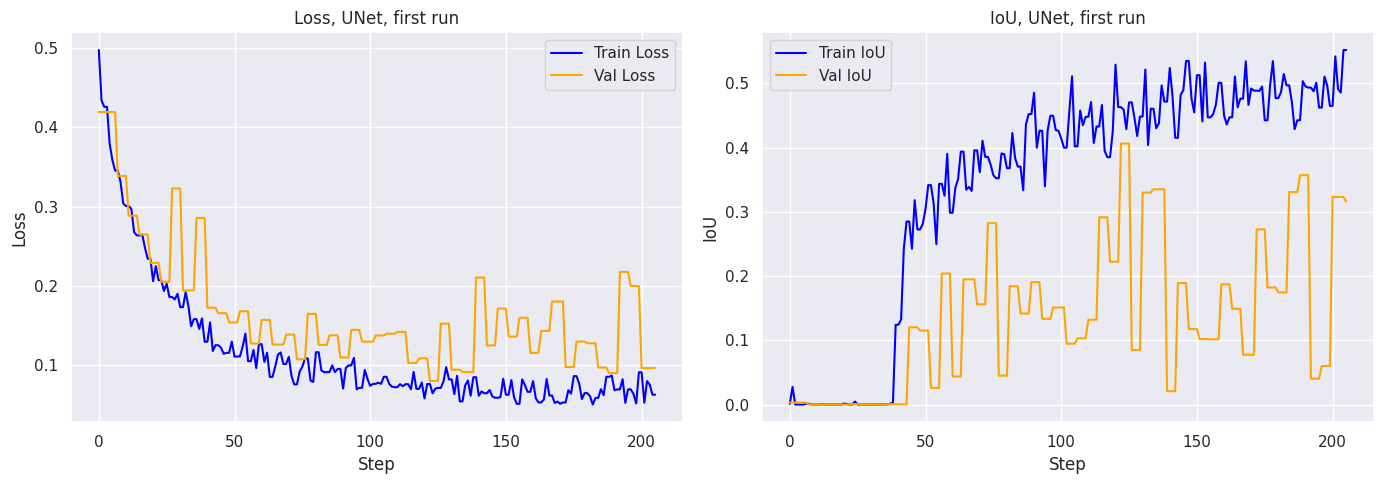

In [13]:
api = wandb.Api()
run_unet_first = api.run('radyasrn-mipt/CV-spring-2025/21p9r6hy')
history_unet_first = run_unet_first.history()

history_unet_first = history_unet_first.fillna(method='ffill')
history_unet_first = history_unet_first.fillna(method='bfill')

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(history_unet_first['train_loss'], color='blue', label='Train Loss')
axs[0].plot(history_unet_first['val_loss'], color='orange', label='Val Loss')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss, UNet, first run')
axs[0].legend()

axs[1].plot(history_unet_first['train_iou'], color='blue', label='Train IoU')
axs[1].plot(history_unet_first['val_iou'], color='orange', label='Val IoU')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('IoU')
axs[1].set_title('IoU, UNet, first run')
axs[1].legend()

plt.tight_layout()
plt.show()

We can see that additional training could be done. We will continue training from the last UNet checkpoint with `lr=1e-5, weight_decay=1e-2` for $50$ epochs:

In [ ]:
wandb.init(project='CV-spring-2025', name='unet-deepglobe-run-39')

checkpoint_path = 'last-unet-deepglobe-folder/last-v5.ckpt'
lightning_unet_deepglobe = UNetLightningModel.load_from_checkpoint(
    checkpoint_path,
    lr=1e-5,
    weight_decay=1e-2
)

checkpoint_callback_unet_deepglobe = ModelCheckpoint(
    monitor='val_iou',
    mode='max',
    dirpath='checkpoints/',
    filename='best-unet-deepglobe',
    save_top_k=1,
    save_last=True
)

trainer_unet_deepglobe = pl.Trainer(
    accelerator='gpu',
    precision='32-true',
    max_epochs=50,
    callbacks=[checkpoint_callback_unet_deepglobe, TQDMProgressBar(refresh_rate=10)],
    logger=pl.loggers.WandbLogger(project='CV-spring-2025', log_model=False)
)

trainer_unet_deepglobe.fit(lightning_unet_deepglobe, train_loader_deepglobe, val_loader_deepglobe)

Then we finish the run:

In [ ]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_iou,▄▃▄▄▃▅▄▃▆▅▄▆▆▅▆▄▁▂▃▄▅▅▄▅▅█▅▃▅▅▅▄▆▄▆▃▂▅▆▃
train_loss,▃▅▅▂▅▂▄▇▄▆▃▆▄▅▄▂▁▃█▅▆▅▅▆▃▃▅▃▃▃▇▁▆▃▄▄▅▄▃▅
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
val_iou,▂▂▁▃▄▅▃▄▃▄▂▃▄▄▅▅▅▄▅▆▅▃▄▅▅▅▆▅▇▅▇▆▇▆▇██▇▇▄
val_loss,█▇▇▆▇▆▇▆▅▅▄▇▅▄▄▅▄▅▃▄▃▄▅▅▃▂▃▄▁▃▁▁▂▂▂▁▁▂▂▃
epoch,49
train_iou,0.54695
train_loss,0.06466
trainer/global_step,7799
val_iou,0.56875


Let's look at the results of the both runs for UNet:

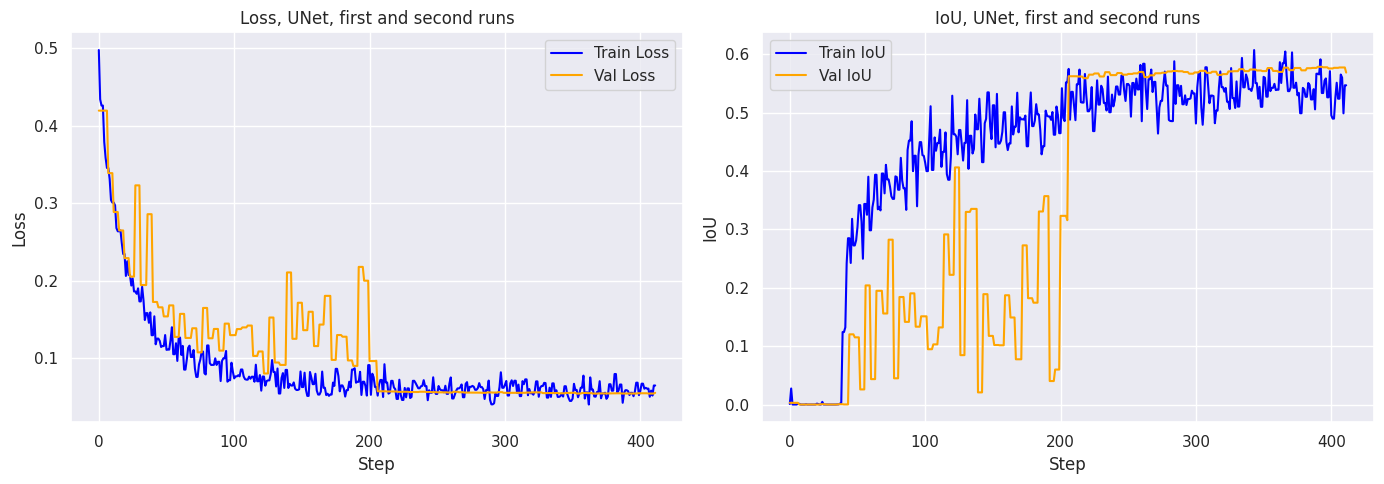

In [14]:
run_unet_second = api.run('radyasrn-mipt/CV-spring-2025/udwihq6y')
history_unet_second = run_unet_second.history()

history_unet_second = history_unet_second.fillna(method='ffill')
history_unet_second = history_unet_second.fillna(method='bfill')
history_unet_second.index += len(history_unet_first)

unet_final_train_loss = pd.concat([history_unet_first['train_loss'], history_unet_second['train_loss']])
unet_final_val_loss = pd.concat([history_unet_first['val_loss'], history_unet_second['val_loss']])

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(unet_final_train_loss, color='blue', label='Train Loss')
axs[0].plot(unet_final_val_loss, color='orange', label='Val Loss')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss, UNet, first and second runs')
axs[0].legend()

unet_final_train_iou = pd.concat([history_unet_first['train_iou'], history_unet_second['train_iou']])
unet_final_val_iou = pd.concat([history_unet_first['val_iou'], history_unet_second['val_iou']])

axs[1].plot(unet_final_train_iou, color='blue', label='Train IoU')
axs[1].plot(unet_final_val_iou, color='orange', label='Val IoU')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('IoU')
axs[1].set_title('IoU, UNet, first and second runs')
axs[1].legend()

plt.tight_layout()
plt.show()

We can see that the additional training helped a lot and the model converged.

Next we will traing the second model, DeepLabV3, with `lr=1e-4, weight_decay=1e-2` for $100$ epochs:

In [ ]:
wandb.init(project='CV-spring-2025', name='deeplabv3-deepglobe-run-8')

lightning_deeplabv3_deepglobe = DeepLabV3LightningModel(lr=1e-4, weight_decay=1e-2)

checkpoint_callback_deeplabv3_deepglobe = ModelCheckpoint(
    monitor='val_iou',
    mode='max',
    dirpath='checkpoints/',
    filename='best-deeplabv3-deepglobe',
    save_top_k=1,
    save_last=True
)

trainer_deeplabv3_deepglobe = pl.Trainer(
    accelerator='gpu',
    precision='32-true',
    max_epochs=100,
    callbacks=[checkpoint_callback_deeplabv3_deepglobe, TQDMProgressBar(refresh_rate=10)],
    logger=pl.loggers.WandbLogger(project='CV-spring-2025', log_model=False)
)

trainer_deeplabv3_deepglobe.fit(lightning_deeplabv3_deepglobe, train_loader_deepglobe, val_loader_deepglobe)

Then we finish the run:

In [ ]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
train_iou,▁▁▁▁▁▁▁▂▁▂▁▂▅▃▃▂▂▂▄▂▂▄▃▆▂▃▄▄▆▄▄▇▅▄▃▄█▇▆▆
train_loss,▇▅▆▇▆▅▄▅▄▆█▃▅▄▃▄▆▄▃▃▆▂▄▄▄▄▄▃▄▁▃▂▁▃▄▄▆▅▆▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇████
val_iou,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▂▃▄▄▄▅▅▅▆▅▄▆▅█▇▅▇▅██▇█▇█
val_loss,▇█▅▅▅▄▄▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,99
train_iou,0.03215
train_loss,0.10405
trainer/global_step,15599
val_iou,0.08922


Let's look at the results of the first run for DeepLabV3:

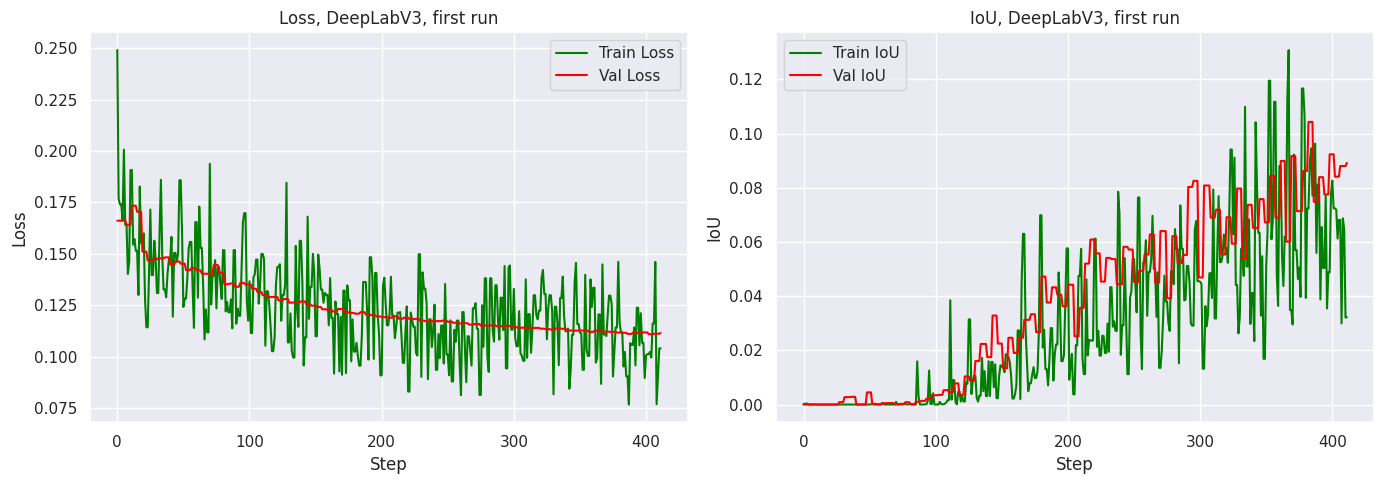

In [15]:
run_deeplabv3_first = api.run('radyasrn-mipt/CV-spring-2025/r9ubn8he')
history_deeplabv3_first = run_deeplabv3_first.history()

history_deeplabv3_first = history_deeplabv3_first.fillna(method='ffill')
history_deeplabv3_first = history_deeplabv3_first.fillna(method='bfill')

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(history_deeplabv3_first['train_loss'], color='green', label='Train Loss')
axs[0].plot(history_deeplabv3_first['val_loss'], color='red', label='Val Loss')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss, DeepLabV3, first run')
axs[0].legend()

axs[1].plot(history_deeplabv3_first['train_iou'], color='green', label='Train IoU')
axs[1].plot(history_deeplabv3_first['val_iou'], color='red', label='Val IoU')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('IoU')
axs[1].set_title('IoU, DeepLabV3, first run')
axs[1].legend()

plt.tight_layout()
plt.show()

We can see that DeepLabV3 is losing to UNet. Let's try to continue training with `lr=7e-5, weight_decay=1e-2` and see if the quality gets better:

In [ ]:
wandb.init(project='CV-spring-2025', name='deeplabv3-deepglobe-run-9')

checkpoint_path = 'checkpoints/last-v10.ckpt'
lightning_deeplabv3_deepglobe = DeepLabV3LightningModel.load_from_checkpoint(
    checkpoint_path,
    lr=7e-5,
    weight_decay=1e-2
)

checkpoint_callback_deeplabv3_deepglobe = ModelCheckpoint(
    monitor='val_iou',
    mode='max',
    dirpath='checkpoints/',
    filename='best-deeplabv3-deepglobe',
    save_top_k=1,
    save_last=True
)

torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
trainer_deeplabv3_deepglobe = pl.Trainer(
    accelerator='gpu',
    precision='32-true',
    max_epochs=50,
    callbacks=[checkpoint_callback_deeplabv3_deepglobe, TQDMProgressBar(refresh_rate=10)],
    logger=pl.loggers.WandbLogger(project='CV-spring-2025', log_model=False)
)

trainer_deeplabv3_deepglobe.fit(lightning_deeplabv3_deepglobe, train_loader_deepglobe, val_loader_deepglobe)

Then we finish the run:

In [ ]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
train_iou,▂▂▅▅▂▁▁▅▁▂▁▃▂▃▄▂▄▃▄▁▂▄▂▃▄▆▃▆▅█▆▂▅▃▂▃
train_loss,▅▅▄▆█▇▅▄▄▃▇▆▄▅▃▃▄▄▄▆▄▄▅▅▃▂▄▄▆▂▄▄▁▃▇▄
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_iou,▄▆▇▁▅▆▆██▆▆
val_loss,▅▆█▇▆▃▂▃▃▃▁
epoch,11
train_iou,0.06401
train_loss,0.1084
trainer/global_step,1799
val_iou,0.09413


Now let's compare the final models:

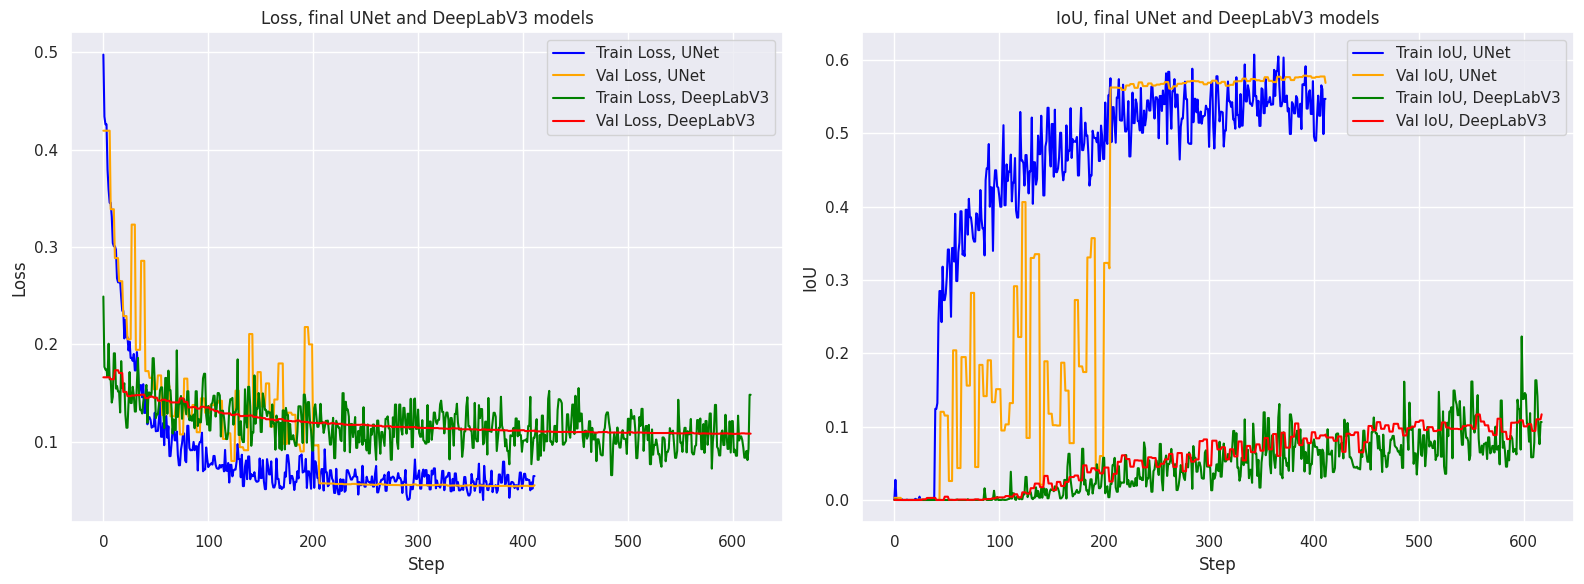

In [16]:
run_deeplabv3_second = api.run('radyasrn-mipt/CV-spring-2025/h7i8c6bn')
history_deeplabv3_second = run_deeplabv3_second.history()

history_deeplabv3_second = history_deeplabv3_second.fillna(method='ffill')
history_deeplabv3_second = history_deeplabv3_second.fillna(method='bfill')
history_deeplabv3_second.index += len(history_deeplabv3_first)

deeplabv3_final_train_loss = pd.concat([history_deeplabv3_first['train_loss'], history_deeplabv3_second['train_loss']])
deeplabv3_final_val_loss = pd.concat([history_deeplabv3_first['val_loss'], history_deeplabv3_second['val_loss']])

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(unet_final_train_loss, color='blue', label='Train Loss, UNet')
axs[0].plot(unet_final_val_loss, color='orange', label='Val Loss, UNet')
axs[0].plot(deeplabv3_final_train_loss, color='green', label='Train Loss, DeepLabV3')
axs[0].plot(deeplabv3_final_val_loss, color='red', label='Val Loss, DeepLabV3')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss, final UNet and DeepLabV3 models')
axs[0].legend()

deeplabv3_final_train_iou = pd.concat([history_deeplabv3_first['train_iou'], history_deeplabv3_second['train_iou']])
deeplabv3_final_val_iou = pd.concat([history_deeplabv3_first['val_iou'], history_deeplabv3_second['val_iou']])

axs[1].plot(unet_final_train_iou, color='blue', label='Train IoU, UNet')
axs[1].plot(unet_final_val_iou, color='orange', label='Val IoU, UNet')
axs[1].plot(deeplabv3_final_train_iou, color='green', label='Train IoU, DeepLabV3')
axs[1].plot(deeplabv3_final_val_iou, color='red', label='Val IoU, DeepLabV3')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('IoU')
axs[1].set_title('IoU, final UNet and DeepLabV3 models')
axs[1].legend()

plt.tight_layout()
plt.show()

We can see that UNet significantly outperforms DeepLabV3, so we will use UNet from now on.

<a name="step-13-application-to-mipt-campus"></a>
<b><font size=3>**Step 1.3:**</font></b>

In this step, we will be segmenting roads from satellite images.

Let's write down the coordinates of Dolgoprudny (the city where MIPT is located):

In [ ]:
latitude = 55.930042
longitude = 37.513009

Then calculate the width and length of the area that we want to consider in degrees , based on the formulas:

$$ distance\_degrees\_latitude = \frac{distance\_km}{111.32}$$

$$ distance\_degrees\_longitude = \frac{distance\_km}{111.32 \cdot cos(latitude)} $$

In [ ]:
square_side_size_km = 0.5

distance_degrees_latitude = square_side_size_km / 111.32

distance_degrees_longitude = square_side_size_km / (111.32 * np.cos(latitude / np.pi))

Now we will fix the upper left corner of the area under consideration, move down and to the right from it, loading satellite images at $0.5$km x $0.5$km in the maximum available image ($450$x$450$):

In [ ]:
blocks_in_width = 3
blocks_in_height = 5

left_upper_corner_latitude = 55.940348
left_upper_corner_longitude = 37.502740

side_size = 450
tiles = []
for i in tqdm(range(blocks_in_height)):
  row = []
  for j in tqdm(range(blocks_in_width), leave=False):
    time.sleep(0.1)
    lat_tile_left_lower_corner = np.round(left_upper_corner_latitude - (i + 1) * distance_degrees_latitude, 8)
    lon_tile_left_lower_corner = np.round(left_upper_corner_longitude + j * distance_degrees_longitude, 8)
    lat_tile_right_upper_corner = np.round(left_upper_corner_latitude - i * distance_degrees_latitude, 8)
    lon_tile_right_upper_corner = np.round(left_upper_corner_longitude + (j + 1) * distance_degrees_longitude, 8)
    url = f'https://static-maps.yandex.ru/1.x/?bbox={lon_tile_left_lower_corner},{lat_tile_left_lower_corner}~{lon_tile_right_upper_corner},{lat_tile_right_upper_corner}&l=sat&size={side_size},{side_size}'
    r = requests.get(url)
    img = Image.open(BytesIO(r.content))
    row.append(np.array(img))
  tiles.append(row)

rows = [np.hstack(row) for row in tiles]
full_image = np.vstack(rows)

plt.figure(figsize=(12, 12))
plt.imshow(full_image)
plt.axis('off')
plt.show()

![Roadmap1](../images/roadmap1.png)

We can see watermarks, as well as the fact that the images are slightly “off” (due to the fact that the Earth is not flat and is an ellipsoid). Let's try to fix this manually by removing the watermarks and shifting the images slightly to the left:

In [ ]:
cut_lower = 75
cut_left = 32

tiles_another = []
for i in tqdm(range(blocks_in_height)):
  row_another = []
  for j in tqdm(range(blocks_in_width), leave=False):
    real_cut_left = 0
    if j > 0:
      real_cut_left = cut_left
    row_another.append(tiles[i][j][:-cut_lower, real_cut_left:, :])
  tiles_another.append(row_another)

rows_another = [np.hstack(row_another) for row_another in tiles_another]
full_image_another = np.vstack(rows_another)

plt.figure(figsize=(12, 12))
plt.imshow(full_image_another)
plt.axis('off')
plt.show()

![Roadmap2](../images/roadmap2.png)

Now it looks much better. Let's load the model:

In [ ]:
lightning_unet_deepglobe = UNetLightningModel.load_from_checkpoint(
    'checkpoints/best-unet-deepglobe-v6.ckpt',
    lr=1e-5,
    weight_decay=1e-2
).to('cuda')

lightning_unet_deepglobe.eval()

Next, we want to apply the model to the satellite image in parts, since the image is quite large. In this situation, we will most likely end up with “seams” at the edges of the parts. We will try to eliminate them in two ways:

* We will take slightly larger parts with overlap, and average the predictions in the overlap

* Apply Gaussian blur to standard-sized parts

Let's look at the predicted road map with smoothing through averaging in overlapping areas:

In [ ]:
mask_overlap = predict_mask_grid(
    full_image_another,
    lightning_unet_deepglobe,
    block_size=side_size,
    smoothing_type='overlap',
    overlap_px=100,
    gaussian_sigma=2
)

image_copy = full_image_another.copy()
mask_bool = mask_overlap > 0
image_copy[mask_bool] = (255, 0, 0)

plt.figure(figsize=(12, 12))
plt.imshow(image_copy)
plt.axis('off')
plt.show()

![Roadmap3](../images/roadmap3.png)

Let's look at the predicted road map with smoothing using Gaussian blur:

In [ ]:
mask_gaussian = predict_mask_grid(
    full_image_another,
    lightning_unet_deepglobe,
    block_size=side_size,
    smoothing_type='gaussian',
    overlap_px=100,
    gaussian_sigma=1
)

image_copy = full_image_another.copy()
mask_bool = mask_gaussian > 0
image_copy[mask_bool] = (255, 0, 0)

plt.figure(figsize=(12, 12))
plt.imshow(image_copy)
plt.axis('off')
plt.show()

![Roadmap4](../images/roadmap4.png)

We can see that each method has its drawbacks:

* Gaussian blur “breaks” thin roads, unlike averaging.
* Averaging can “break” large roads, unlike blurring.

Therefore, we combine these methods for different values of averaging and blurring:

In [ ]:
mask_combined = np.zeros((full_image_another.shape[0], full_image_another.shape[1]), dtype=np.int64)

overlap_values = [10, 20, 50, 100, 225]
gaussian_blur_values = [0.5, 1, 2, 3, 4, 5]

for overlap_value in overlap_values:
  mask_combined += predict_mask_grid(
      full_image_another,
      lightning_unet_deepglobe,
      block_size=side_size,
      smoothing_type='overlap',
      overlap_px=overlap_value,
      gaussian_sigma=1
  )

for gaussian_blur_value in gaussian_blur_values:
  mask_combined += predict_mask_grid(
      full_image_another,
      lightning_unet_deepglobe,
      block_size=side_size,
      smoothing_type='gaussian',
      overlap_px=overlap_value,
      gaussian_sigma=gaussian_blur_value
  )

mask_combined[mask_combined > 0] = 255

image_copy = full_image_another.copy()
mask_bool = mask_combined > 0
image_copy[mask_bool] = (255, 0, 0)

plt.figure(figsize=(12, 12))
plt.imshow(image_copy)
plt.axis('off')
plt.show()

![Roadmap5](../images/roadmap5.png)

---
<a name="part-2-road-network-graph-construction"></a>
# <b><font size=5>**Part 2:**</font></b>

In this part, we will construct a road graph from the road map obtained by segmentation earlier. Road graphs are extremely useful in tasks such as delivery planning or taxi ordering by users.

<a name="step-21-skeletonization"></a>
<b><font size=3>**Step 2.1:**</font></b>

In this step, we will build a skeleton:

In [ ]:
binary_mask = (mask_combined > 0).astype(np.uint8)

skeleton = skeletonize(binary_mask).astype(np.uint8)

skeleton *= 255

plt.figure(figsize=(12, 12))
plt.title('Skeletonized mask')
plt.imshow(skeleton, cmap='gray')
plt.axis('off')
plt.savefig('part2-step1-skeleton.png')

binary_skeleton = (skeleton > 0).astype(np.uint8)
skeleton_dilated = cv2.dilate(binary_skeleton, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))

image_copy = full_image_another.copy()
image_copy[skeleton_dilated == 1] = [0, 255, 255]

plt.figure(figsize=(12, 12))
plt.imshow(image_copy)
plt.title('Satellite image, skeleton marked in blue')
plt.axis('off')
plt.savefig('part2-step1-satellite.png')

| Skeleton | Satellite |
|---|---|
| ![Skeleton](images/part2-step1-skeleton.png) | ![Satellite](images/part2-step1-satellite.png) |

<a name="step-22-graph-node-extraction"></a>
<b><font size=3>**Step 2.2:**</font></b>

In this step, we will get graph nodes.

Let's count the number of neighbors (excluding itself) for each point using convolution, then highlight intersections (at least $3$ neighbors) and dead ends ($1$ neighbor):

In [ ]:
neighbor_kernel = np.array([
  [1, 1, 1],
  [1, 0, 1],
  [1, 1, 1]
], dtype=np.uint8)

neighbor_count = convolve(binary_skeleton, neighbor_kernel, mode='constant', cval=0)

# intersections
intersection_mask = ((binary_skeleton == 1) & (neighbor_count >= 3)).astype(np.uint8)

# dead ends
dead_end_mask = ((binary_skeleton == 1) & (neighbor_count == 1)).astype(np.uint8)

Let's look at the result:

In [ ]:
skeleton_rgb = np.stack([binary_skeleton * 255] * 3, axis=-1)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
intersections_dilated = cv2.dilate(intersection_mask, kernel)
dead_ends_dilated = cv2.dilate(dead_end_mask, kernel)

skeleton_rgb[intersections_dilated == 1] = [0, 255, 0]
skeleton_rgb[dead_ends_dilated == 1] = [255, 0, 0]

plt.figure(figsize=(12, 12))
plt.imshow(skeleton_rgb)
plt.title('Skeleton with nodes: green — intersections, red — dead ends')
plt.axis('off')
plt.savefig('part2-step2-skeleton.png')

skeleton_dilated = cv2.dilate(binary_skeleton, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
image_copy = full_image_another.copy()
image_copy[skeleton_dilated == 1] = [0, 255, 255]
image_copy[intersections_dilated == 1] = [0, 255, 0]
image_copy[dead_ends_dilated == 1] = [255, 0, 0]

plt.figure(figsize=(12, 12))
plt.imshow(image_copy)
plt.title('Satellite image, skeleton marked in blue, intersections in green, dead ends in red')
plt.axis('off')
plt.savefig('part2-step2-satellite.png')

<p float="left">
  <img src="../images/part2-step2-skeleton.png" width="400" />
  <img src="../images/part2-step2-satellite.png" width="400" />
</p>

As you can see, we are able to identify real intersections and dead ends quite well. However, there are also false positives, but this is due to the fact that we cannot segment roads perfectly.

<a name="step-23-point-clustering"></a>
<b><font size=3>**Step 2.3:**</font></b>

In this step, we will perform clustering.

Since several points may correspond to one intersection, we need to perform clustering. We need a clustering algorithm that does not require specifying the number of clusters and that operates with density. DBSCAN is well suited for this, so we will use it.

Based on the image we saw earlier, the points corresponding to a single intersection appear to lie within a circle with a radius of $30$ pixels. In our case, a single key point in the neighborhood is sufficient for the cluster to be counted.

Since it is unlikely that we will be able to find better parameters, we will use `eps=30, min_samples=1`:

In [ ]:
intersection_centers = cluster_mask_points(intersection_mask, eps=30, min_samples=1)
dead_end_centers = cluster_mask_points(dead_end_mask, eps=30, min_samples=1)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Let's look at the result:

In [ ]:
intersection_clusters_mask = np.zeros_like(skeleton, dtype=np.uint8)
dead_end_clusters_mask = np.zeros_like(skeleton, dtype=np.uint8)

for y, x in intersection_centers:
  intersection_clusters_mask[y, x] = 1

for y, x in dead_end_centers:
  dead_end_clusters_mask[y, x] = 1

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
intersections_dilated = cv2.dilate(intersection_clusters_mask, kernel)
dead_ends_dilated = cv2.dilate(dead_end_clusters_mask, kernel)

skeleton_rgb = np.stack([binary_skeleton * 255] * 3, axis=-1)

skeleton_rgb[intersections_dilated == 1] = [0, 255, 0]
skeleton_rgb[dead_ends_dilated == 1] = [255, 0, 0]

plt.figure(figsize=(12, 12))
plt.imshow(skeleton_rgb)
plt.title('Skeleton with nodes: green — intersections, red — dead ends')
plt.axis('off')
plt.savefig('part2-step3-skeleton.png')

image_copy = full_image_another.copy()
image_copy[skeleton_dilated == 1] = [0, 255, 255]
image_copy[intersections_dilated == 1] = [0, 255, 0]
image_copy[dead_ends_dilated == 1] = [255, 0, 0]

plt.figure(figsize=(12, 12))
plt.imshow(image_copy)
plt.title('Satellite image, skeleton marked in blue, intersections in green, dead ends in red')
plt.axis('off')
plt.savefig('part2-step3-satellite.png')

<p float="left">
  <img src="../images/part2-step3-skeleton.png" width="400" />
  <img src="../images/part2-step3-satellite.png" width="400" />
</p>

<a name="step-23-graph-edge-extraction"></a>
<b><font size=3>**Step 2.4:**</font></b>

In this step, we will get graph edges.

Let's make a skeleton without intersections:

In [ ]:
skeleton_wo_junctions = binary_skeleton.copy()
for y, x in intersection_centers:
  skeleton_wo_junctions[y, x] = 0

Let's obtain the connectivity components and lines along them:

In [ ]:
labeled = label(skeleton_wo_junctions, connectivity=2)
regions = regionprops(labeled)

lines = []

for region in regions:
  coords = region.coords
  if len(coords) < 2:  # it is impossible to draw a line with fewer than two points
    continue
  coords = [(x, y) for y, x in coords]
  line = LineString(coords)
  lines.append(line)

Let's look at the result:

In [ ]:
plt.figure(figsize=(12, 12))

plt.imshow(binary_skeleton, cmap='gray')
for line in lines:
  x, y = line.xy
  plt.scatter(x, y, color='cyan', s=[7] * len(x))

plt.title('The skeleton and resulting lines are marked in blue')
plt.axis('off')
plt.savefig('part2-step4-skeleton.png')

image_copy = full_image_another.copy()

plt.figure(figsize=(12, 12))

plt.imshow(image_copy)
for line in lines:
  x, y = line.xy
  plt.scatter(x, y, color='cyan', s=[7] * len(x))

plt.title('Satellite image, the resulting lines are marked in blue')
plt.axis('off')
plt.savefig('part2-step4-satellite.png')

<p float="left">
  <img src="../images/part2-step4-skeleton.png" width="400" />
  <img src="../images/part2-step4-satellite.png" width="400" />
</p>

<a name="step-23-final-graph"></a>
<b><font size=3>**Step 2.5:**</font></b>

In this step, we will obtain the final graph.

Let's combine all the points obtained earlier into a KD tree for quick search of nearest neighbors:

In [ ]:
all_nodes = np.vstack([intersection_centers, dead_end_centers])

node_tree = KDTree(all_nodes)

Let's create a graph:

In [ ]:
G = nx.Graph()

for i, (y, x) in enumerate(all_nodes):
  G.add_node(i, pos=(x, y))

for line in lines:
  boundary = line.boundary
  if boundary.geom_type != 'MultiPoint':
    continue

  p1, p2 = boundary.geoms
  x1, y1 = p1.x, p1.y
  x2, y2 = p2.x, p2.y

  idx1 = node_tree.query([y1, x1])[1]
  idx2 = node_tree.query([y2, x2])[1]

  if idx1 != idx2 and not G.has_edge(idx1, idx2):
    length = line.length
    G.add_edge(idx1, idx2, geometry=line, weight=length)

Then let's look at the result:

In [ ]:
plot_graph_overlay(full_image_another, G, title='Graph on satellite image, nodes are green, edge reference points are blue', save_name='part2-step5-satellite.png')

mask_rgb = np.stack([full_image_another_mask * 3, np.zeros_like(full_image_another_mask), np.zeros_like(full_image_another_mask)] , axis=-1)
plot_graph_overlay(mask_rgb, G, title='Graph on the red segmentation mask, nodes are green, edge support points are blue', save_name='part2-step5-mask.png')

<p float="left">
  <img src="../images/part2-step5-mask.png" width="400" />
  <img src="../images/part2-step5-satellite.png" width="400" />
</p>